In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from datetime import datetime

%matplotlib inline
sns.set_style('whitegrid')
# read the cleaned data
data = pd.read_csv("ProcessedData.csv")

#drop car brand names
data_rm_brand = data.drop('Brand', axis=1)

#change car Registration Dates str type to datetime type
data_rm_brand['Registration Date'] = pd.to_datetime(data['Registration Date'])
data_rm_brand['Registration Date'].dtypes

#encode Transmission (Auto='1', Manual='0')
#Define a mapping dictionary
mapping_dict = {'Auto': 1, 'Manual': 0}

# Apply the mapping to the "Transmission" column
data_rm_brand['Transmission'] = data_rm_brand['Transmission'].map(mapping_dict)

#Rename the column to 'Transmission' to reflect encoding
data_rm_brand.rename(columns={'Transmission': 'Transmission'}, inplace=True)

#encode car types
# Define a mapping dictionary
mapping_dict2 = {'Hatchback': 1,'Mid-Sized Sedan': 2, 'MPV': 3, 'Luxury Sedan': 4, 'SUV': 5, 'Sports Car': 6, 'Stationwagon': 7}

# Apply the mapping to the "Vehicle Type" column
data_rm_brand['Vehicle Type'] = data_rm_brand['Vehicle Type'].map(mapping_dict2)

#Rename 'Vehicle Type' to reflect encoding
data_rm_brand.rename(columns={'Vehicle Type': 'Vehicle Type'}, inplace=True)

data_rm_brand.head()

,Price,Depreciation,Road Tax,Registration Date,COE Left,Mileage,Manufacture Year,Transmission,Deregistration,OMV,ARF,COE Price,Engine Capacity,Power,Curb Weight,No. Of Owners,Vehicle Type
0,45800,17150,684,2015-09-30,404,111000,2015,1,25177,26376,23927,61010,1499,100.0,1360,3,1
1,14000,13460,620,2014-05-14,213,115000,2013,1,9586,21478,12070,60002,1390,90.0,1417,2,2
2,44800,13870,508,2016-10-28,1102,88000,2016,1,18799,14938,5000,50991,1198,72.0,1081,1,1
3,75800,17820,684,2017-02-01,1186,90800,2016,1,40186,33244,33542,55501,1499,100.0,1550,2,3
4,39888,15910,624,2015-12-29,798,110000,2015,1,17545,19158,9158,54301,1395,90.0,1249,2,1


In [133]:
# Convert the Series object to a datetime object using the `to_datetime()` function.
registration_date_datetime = pd.to_datetime(data_rm_brand['Registration Date'], format='%y-%m-%d')

# Encode the registration date to an integer.
encoded_registration_date = registration_date_datetime.dt.year * 10000 + registration_date_datetime.dt.month * 100 + registration_date_datetime.dt.day

print(encoded_registration_date)
encoded_registration_date = encoded_registration_date.astype(int)


0       20150930
1       20140514
2       20161028
3       20170201
4       20151229
          ...   
2958    20170316
2959    20170328
2960    20190723
2961    20151109
2962    20180117
Name: Registration Date, Length: 2963, dtype: int32


In [134]:
data_rm_brand.corr()

,Price,Depreciation,Road Tax,Registration Date,COE Left,Mileage,Manufacture Year,Transmission,Deregistration,OMV,ARF,COE Price,Engine Capacity,Power,Curb Weight,No. Of Owners,Vehicle Type
Price,1.000000,0.405879,0.390903,0.320331,0.473183,-0.438123,0.291822,0.011523,0.486421,0.470934,0.496691,0.224759,0.448740,0.611883,0.393659,-0.072315,0.327906
Depreciation,0.405879,1.000000,0.586243,0.157050,0.072826,-0.261896,0.147556,-0.023524,0.794937,0.859680,0.838527,0.243545,0.654142,0.704537,0.453314,-0.015866,0.259325
Road Tax,0.390903,0.586243,1.000000,-0.270211,0.168138,0.023599,-0.252921,-0.033340,0.474442,0.788761,0.693226,0.155582,0.957364,0.834606,0.643310,0.307436,0.353620
Registration Date,0.320331,0.157050,-0.270211,1.000000,0.336787,-0.767030,0.927686,0.124698,0.364460,0.038120,0.075226,0.239019,-0.139026,-0.022596,0.010461,-0.670616,0.023325
COE Left,0.473183,0.072826,0.168138,0.336787,1.000000,-0.458235,0.291434,-0.020268,0.356746,0.212240,0.171326,0.118988,0.138943,0.192301,0.090604,-0.090974,0.140647
Mileage,-0.438123,-0.261896,0.023599,-0.767030,-0.458235,1.000000,-0.710976,-0.078804,-0.428540,-0.213532,-0.228747,-0.237302,-0.051045,-0.156941,-0.050229,0.512752,-0.084782
Manufacture Year,0.291822,0.147556,-0.252921,0.927686,0.291434,-0.710976,1.000000,0.153483,0.340312,0.036665,0.069355,0.245643,-0.164141,-0.027744,0.004158,-0.634321,0.005360
Transmission,0.011523,-0.023524,-0.033340,0.124698,-0.020268,-0.078804,0.153483,1.000000,0.001945,-0.002684,-0.010550,0.042483,-0.020774,-0.035271,0.067601,-0.107847,-0.046864
Deregistration,0.486421,0.794937,0.474442,0.364460,0.356746,-0.428540,0.340312,0.001945,1.000000,0.764029,0.825012,0.380672,0.560702,0.641668,0.454746,-0.157855,0.250035
OMV,0.470934,0.859680,0.788761,0.038120,0.212240,-0.213532,0.036665,-0.002684,0.764029,1.000000,0.876838,0.255044,0.812724,0.825119,0.563720,0.100029,0.318374


In [135]:
# How each feature relates to price
data_rm_brand.corr()['Price'].sort_values(ascending=False)

Price                1.000000
Power                0.611883
ARF                  0.496691
Deregistration       0.486421
COE Left             0.473183
OMV                  0.470934
Engine Capacity      0.448740
Depreciation         0.405879
Curb Weight          0.393659
Road Tax             0.390903
Vehicle Type         0.327906
Registration Date    0.320331
Manufacture Year     0.291822
COE Price            0.224759
Transmission         0.011523
No. Of Owners       -0.072315
Mileage             -0.438123
Name: Price, dtype: float64

(17.5, -0.5)

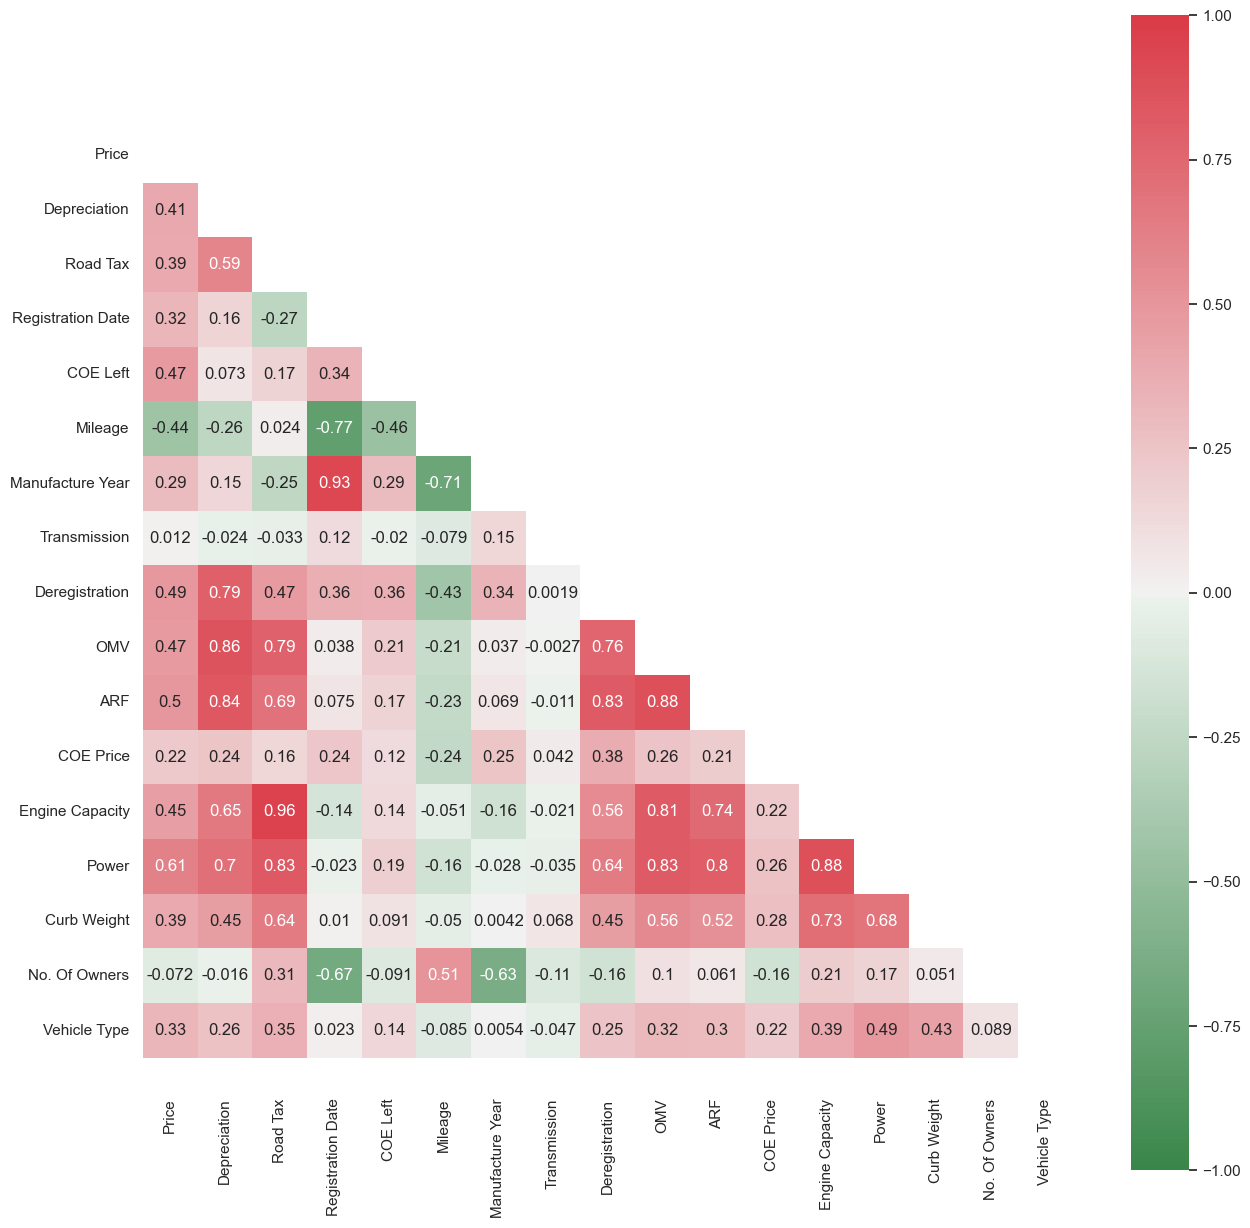

In [136]:
# Corr Matrix Heatmap Visualization

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data_rm_brand.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(15,15))

# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
sns.heatmap(data_rm_brand.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1,ax=ax);
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [137]:
# Drop the unwanted columns
data_rm_brand.drop(['Depreciation','Registration Date','Manufacture Year','ARF','Engine Capacity','Power'],axis=1,inplace=True)

# Get the remaining columns
remaining_columns = data_rm_brand.columns

# Save the remaining columns to a CSV file
data_rm_brand.to_csv('remaining_columns.csv', index=False, columns=remaining_columns)

In [138]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming X is your feature data and y is your target variable
data_rm_brand = pd.read_csv('remaining_columns.csv')

# Split the data into input features (X) and target variable (y)
X = data_rm_brand
y = data_rm_brand['Price']

# RFE for XGBoost
xgb_model = XGBRegressor()
rfe_xgb = RFE(estimator=xgb_model, n_features_to_select=10)  # Adjust the number of features to select as needed
rfe_xgb.fit(X, y)
selected_features_xgb = X.columns[rfe_xgb.support_]

# RFE for Linear Regression
lr_model = LinearRegression()
rfe_lr = RFE(estimator=lr_model, n_features_to_select=10)  # Adjust the number of features to select as needed
rfe_lr.fit(X, y)
selected_features_lr = X.columns[rfe_lr.support_]

# RFE for RandomForest
rf_model = RandomForestRegressor()
rfe_rf = RFE(estimator=rf_model, n_features_to_select=10)  # Adjust the number of features to select as needed
rfe_rf.fit(X, y)
selected_features_rf = X.columns[rfe_rf.support_]

# Combine selected features from all models (intersection)
selected_features = list(set(selected_features_xgb) & set(selected_features_lr) & set(selected_features_rf))

# Create a new dataset with selected features by ML model
selected_X = X[selected_features]

selected_X.to_csv('MLselected_columns.csv', index=False, columns=selected_X)

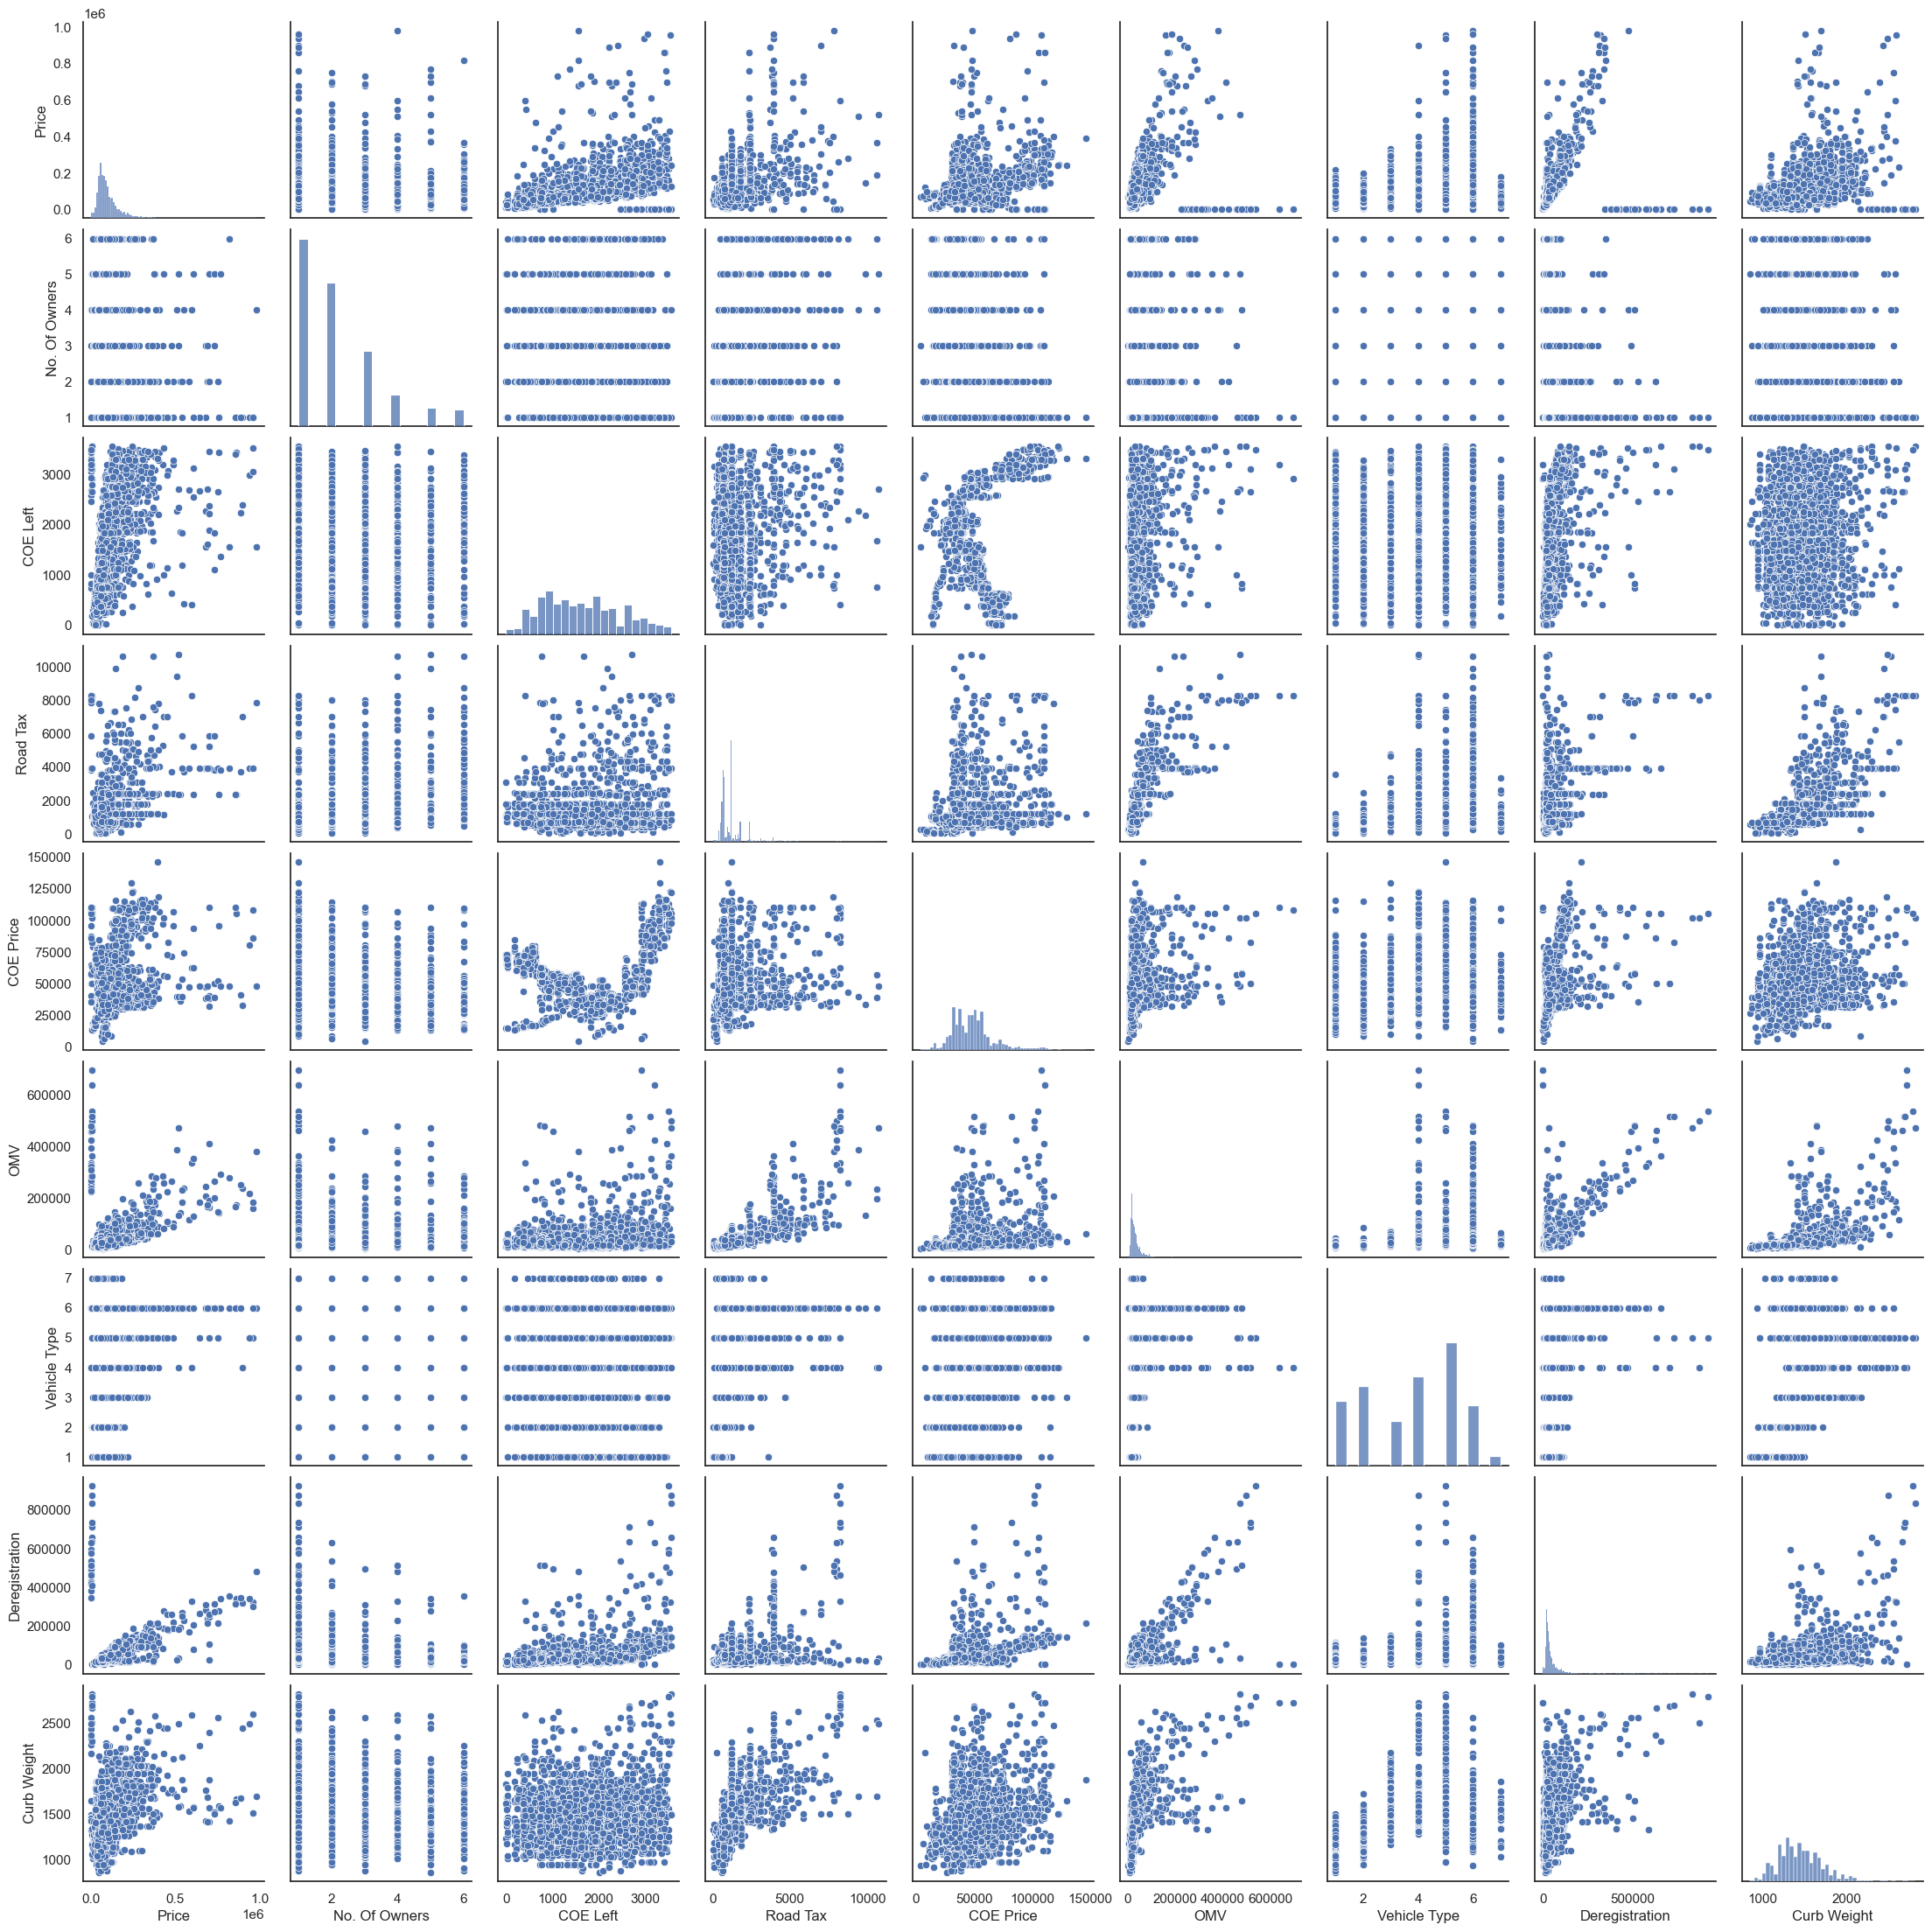

In [139]:
# ML selected variables
sns.pairplot(selected_X);

/var/folders/bf/d3x6nd1n1_q1_sxrfpb42_ch0000gn/T/ipykernel_60560/2392374282.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.DataFrame.hist(selected_X,ax=ax)


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'No. Of Owners'}>,
        <Axes: title={'center': 'COE Left'}>],
       [<Axes: title={'center': 'Road Tax'}>,
        <Axes: title={'center': 'COE Price'}>,
        <Axes: title={'center': 'OMV'}>],
       [<Axes: title={'center': 'Vehicle Type'}>,
        <Axes: title={'center': 'Deregistration'}>,
        <Axes: title={'center': 'Curb Weight'}>]], dtype=object)

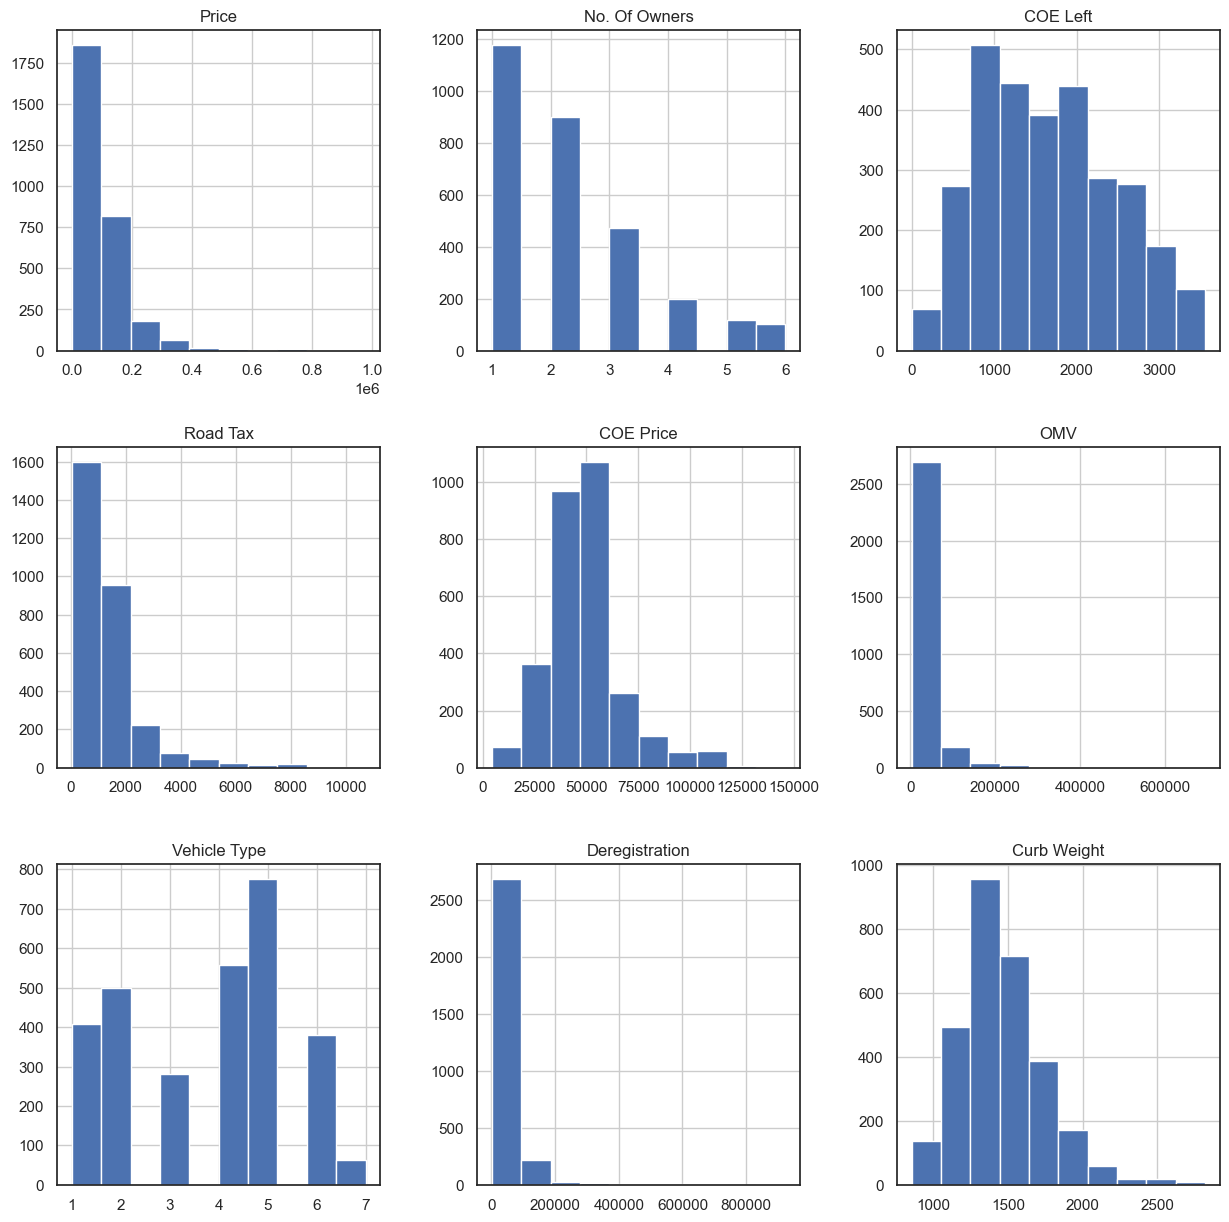

In [140]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(selected_X,ax=ax)

In [142]:
#import numpy as np
#import pandas as pd

data_rm_brand_only_OMV_logged = data_rm_brand.copy()
data_rm_brand_only_OMV_logged['OMV'] = np.log(data_rm_brand_only_OMV_logged['OMV'])
data_rm_brand_only_OMV_logged.head()
data_rm_brand_only_OMV_logged.to_csv('OMV_columns.csv', index=False, columns=remaining_columns)

In [143]:
#import numpy as np
#import pandas as pd

data_rm_brand_only_curbweight_logged = data_rm_brand.copy()
data_rm_brand_only_curbweight_logged['Curb Weight'] = np.log(data_rm_brand_only_curbweight_logged['Curb Weight'])
data_rm_brand_only_curbweight_logged.head()
data_rm_brand_only_curbweight_logged.to_csv('Curb_Weight_columns.csv', index=False, columns=remaining_columns)

In [144]:
#import numpy as np
#import pandas as pd

data_rm_brand_only_roadtax_logged = data_rm_brand.copy()
data_rm_brand_only_roadtax_logged['Road Tax'] = np.log(data_rm_brand_only_roadtax_logged['Road Tax'])
data_rm_brand_only_roadtax_logged.head()
data_rm_brand_only_roadtax_logged.to_csv('Road_Tax_columns.csv', index=False, columns=remaining_columns)

In [145]:
#import numpy as np
#import pandas as pd

data_rm_brand_only_COE_logged = data_rm_brand.copy()
data_rm_brand_only_COE_logged['COE Price'] = np.log(data_rm_brand_only_COE_logged['COE Price'])
data_rm_brand_only_COE_logged.head()
data_rm_brand_only_COE_logged.to_csv('COE_Price_columns.csv', index=False, columns=remaining_columns)

In [146]:
#import numpy as np
#import pandas as pd

data_rm_brand_only_deregisteration_logged = data_rm_brand.copy()
data_rm_brand_only_deregisteration_logged['Deregisteration'] = np.log(data_rm_brand_only_deregisteration_logged['Deregistration'])
data_rm_brand_only_deregisteration_logged.head()
data_rm_brand_only_deregisteration_logged.to_csv('Deregisteration_columns.csv', index=False, columns=remaining_columns)

/var/folders/bf/d3x6nd1n1_q1_sxrfpb42_ch0000gn/T/ipykernel_60560/1040357961.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  selected_X_df.hist(ax=ax)


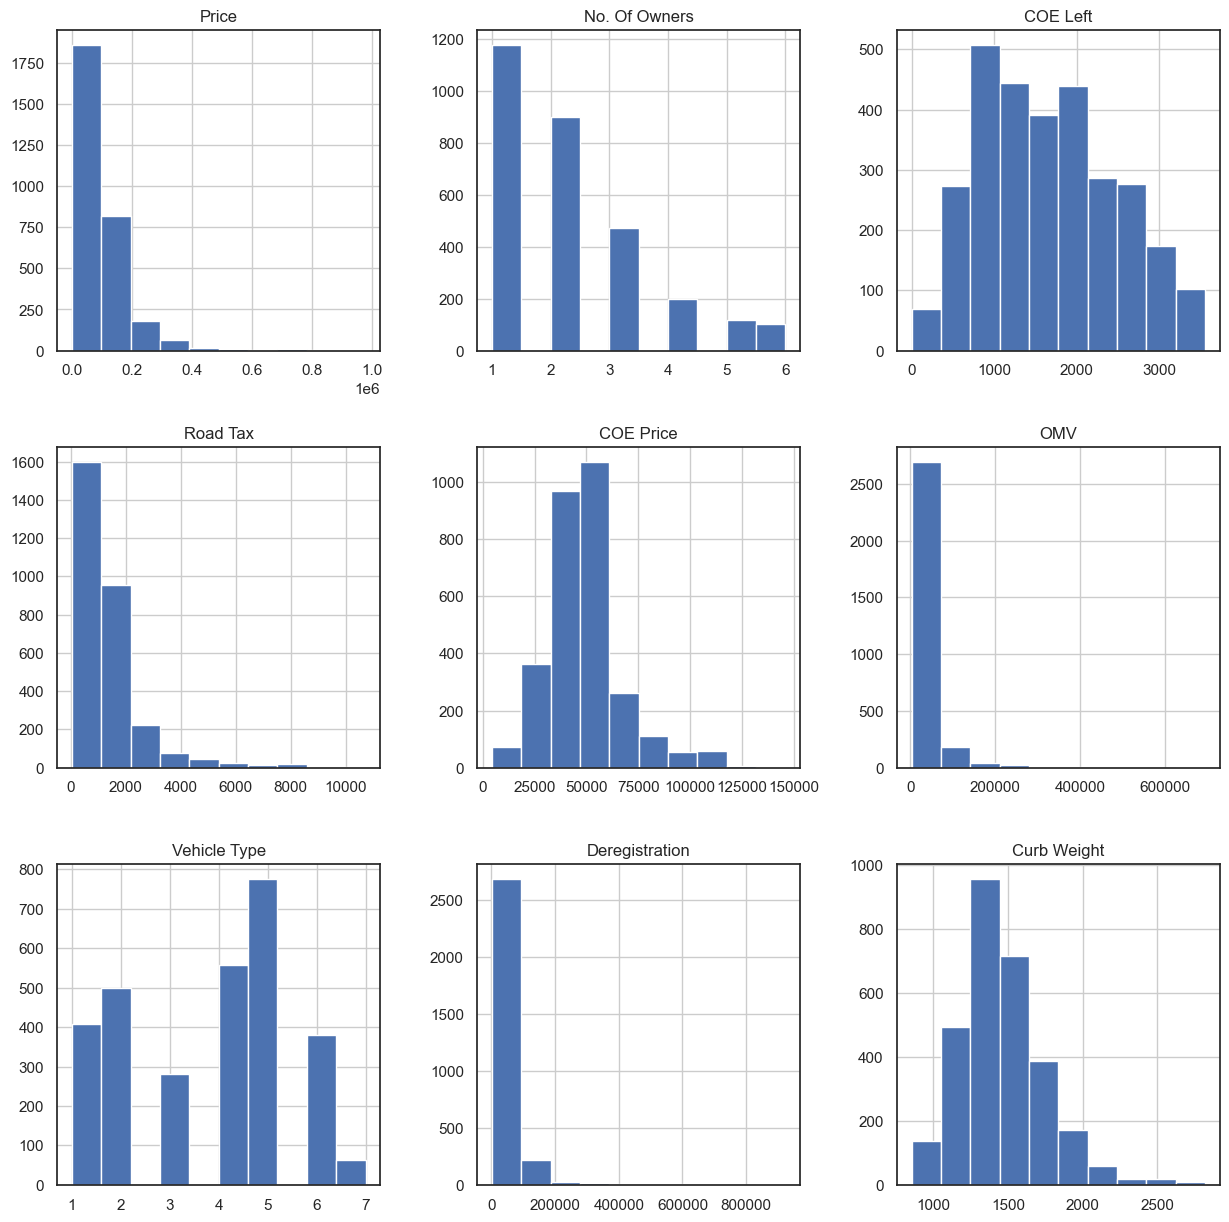

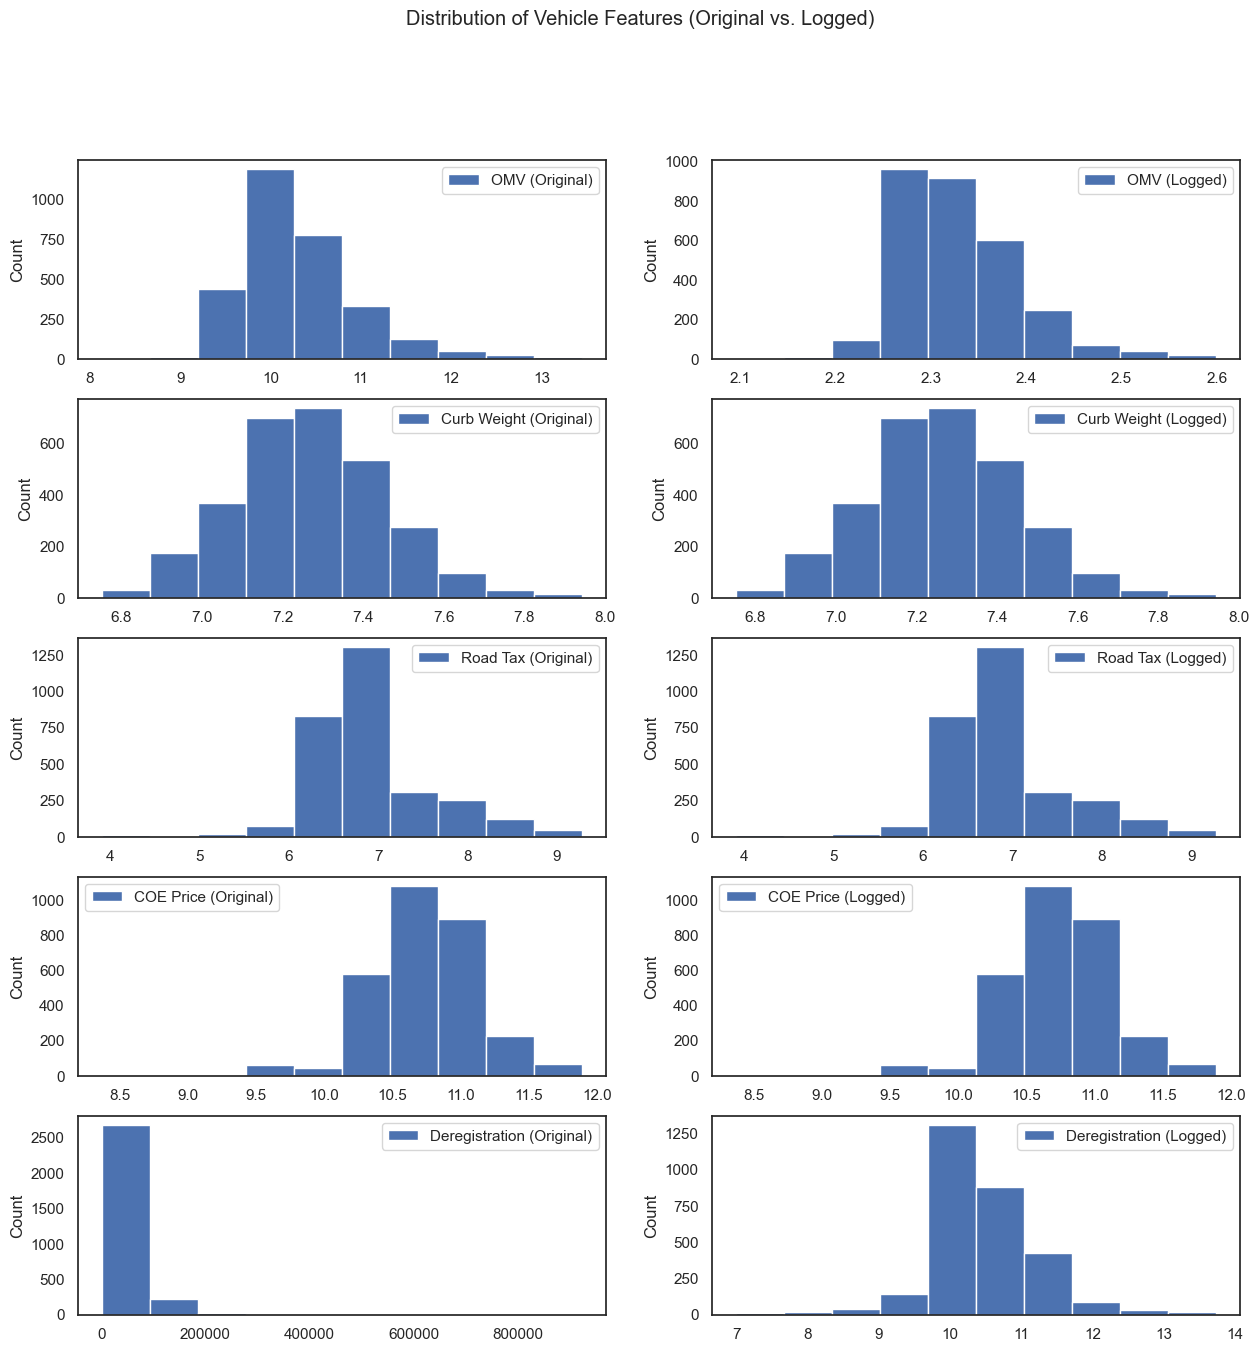

In [148]:
# Original Histogram
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))

# **Import the Pandas DataFrame class**
import pandas as pd

# **Create a Pandas DataFrame from the selected_X data**
selected_X_df = pd.DataFrame(selected_X)

# **Plot the histogram of the selected_X data**
selected_X_df.hist(ax=ax)

# Logged Histogram
data_rm_brand_only_OMV_logged = pd.read_csv('OMV_columns.csv')
data_rm_brand_only_curbweight_logged = pd.read_csv('Curb_Weight_columns.csv')
data_rm_brand_only_roadtax_logged = pd.read_csv('Road_Tax_columns.csv')
data_rm_brand_only_COE_logged = pd.read_csv('COE_Price_columns.csv')
data_rm_brand_only_deregisteration_logged = pd.read_csv('Deregisteration_columns.csv')

# **Import the NumPy library**
import numpy as np

# **Log-transform the data**
logged_data = {}
for column in ['OMV', 'Curb Weight', 'Road Tax', 'COE Price', 'Deregistration']:
    logged_data[column] = np.log(data_rm_brand_only_OMV_logged[column])

# Create a figure and axes object
fig, axs = plt.subplots(5, 2, figsize=(15,15))

# Plot the histograms
axs[0, 0].hist(data_rm_brand_only_OMV_logged['OMV'], label='OMV (Original)')
axs[0, 1].hist(logged_data['OMV'], label='OMV (Logged)')
axs[1, 0].hist(data_rm_brand_only_curbweight_logged['Curb Weight'], label='Curb Weight (Original)')
axs[1, 1].hist(logged_data['Curb Weight'], label='Curb Weight (Logged)')
axs[2, 0].hist(data_rm_brand_only_roadtax_logged['Road Tax'], label='Road Tax (Original)')
axs[2, 1].hist(logged_data['Road Tax'], label='Road Tax (Logged)')
axs[3, 0].hist(data_rm_brand_only_COE_logged['COE Price'], label='COE Price (Original)')
axs[3, 1].hist(logged_data['COE Price'], label='COE Price (Logged)')
axs[4, 0].hist(data_rm_brand_only_deregisteration_logged['Deregistration'], label='Deregistration (Original)')
axs[4, 1].hist(logged_data['Deregistration'], label='Deregistration (Logged)')

# Add titles and labels
plt.suptitle('Distribution of Vehicle Features (Original vs. Logged)')
for ax in axs.ravel():
    ax.set_xlabel(ax.get_title())
    ax.set_ylabel('Count')
    ax.legend()

# Show the plot
plt.show()


In [149]:
import pandas as pd

# Read the two CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')

# Merge the two DataFrames into a single DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging.csv', index=False)


In [150]:
import pandas as pd

# Read the two CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')
df3 = pd.read_csv('Road_Tax_columns.csv')

# Merge the two DataFrames into a single DataFrame
df = pd.concat([df1, df2,df3], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging2.csv', index=False)


In [151]:
import pandas as pd

# Read the two CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')
df3 = pd.read_csv('Road_Tax_columns.csv')
df4 = pd.read_csv('COE_Price_columns.csv')

# Merge the two DataFrames into a single DataFrame
df = pd.concat([df1, df2,df3,df4], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging3.csv', index=False)


In [152]:
import pandas as pd

# Read the two CSV files into Pandas DataFrames
df1 = pd.read_csv('OMV_columns.csv')
df2 = pd.read_csv('Curb_Weight_columns.csv')
df3 = pd.read_csv('Road_Tax_columns.csv')
df4 = pd.read_csv('COE_Price_columns.csv')
df5 = pd.read_csv('Deregisteration_columns.csv')

# Merge the two DataFrames into a single DataFrame
df = pd.concat([df1, df2,df3,df4,df5], ignore_index=True)

# Save the merged DataFrame to a new CSV file
df.to_csv('merged_logging4.csv', index=False)


In [153]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.45677199005109426


In [154]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging2.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.34060893342441134


In [155]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging3.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.4409196887381531


In [157]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging4.csv')
data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.43707563329910004


In [158]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.9472150062225692


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

In [159]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging2.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.9580033607688891


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

In [160]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging3.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)

R2 score: 0.9684520170458867


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

In [162]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging4.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.980124193035333


/Library/Python/3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Python/3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/Library/Python/3.9/site-packages/xgb

In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.9246515428125204


In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging2.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.911425999608523


In [165]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging3.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.9633376982210334


In [166]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the data
data = pd.read_csv('merged_logging4.csv')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('Price', axis=1), data['Price'], test_size=0.25, random_state=42)

# Create a Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R2 score
r2_score = r2_score(y_test, y_pred)

# Print the R2 score
print('R2 score:', r2_score)


R2 score: 0.9805476278069856
